## Generating lists of genes for each cluster).

Click <a href=#dist_to_centroids_results>here</a> to jump directly to the results and <a href=#most_biased_genes>here</a> for the most biased genes within each cluster (links not working when the notebook is displayed in gitlab).

In [1]:
from pathlib import Path
from random import seed
seed(123)

In [2]:
from yaml import safe_load as yload

In [3]:
from libcodonusage import (
    aa2colour, columns_by_aa,
    extract_top_genes_from_cluster,
    find_valley,
    find_most_biased_genes,
    load_bias_table,
    star2stop,
    violin_usage_by_clusters,
    violin_with_thresh,
    write_cluster_lists)

In [4]:
with open("configs/codon_usage_Vcholerae.yaml") as fh:
    config = yload(fh)
config

{'species': 'Vcholerae',
 'assembly': 'GCF_000006745.1_ASM674v1',
 'seq_id_kw': 'locus_tag',
 'alt_tag_kw': 'old_locus_tag'}

In [5]:
species = config["species"]
assembly = config["assembly"]
seq_id_kw = config["seq_id_kw"]
alt_tag_kw = config["alt_tag_kw"]

In [6]:
usage_dir = Path("codon_usage").joinpath(
    "usage_computations", species, assembly)

In [7]:
scub_by_aa_noMW = load_bias_table(
    usage_dir.joinpath(
        "standardized_codon_usage_biases_by_aa_with_aa_based_clusterings.tsv"),
    nb_info_cols=12,
    nb_cluster_series=2)

In [8]:
# Move sequence identifier to the front of the index columns
scub_by_aa_noMW = scub_by_aa_noMW.reorder_levels([
    seq_id_kw,
    *[name for name in scub_by_aa_noMW.index.names if name != seq_id_kw]])

In [9]:
scub_by_aa_noMW.head(3)

A  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        GCA   
locus_tag  old_locus_tag length chrom start end  start_codon expected_start_aa first_stop nb_stops start_upstream end_downstream cluster_A_full_bias cluster_R_full_bias cluster_N_full_bias cluster_D_full_bias cluster_C_full_bias cluster_Q_full_bias cluster_E_full_bias cluster_G_full_bias cluster_H_full_bias cluster_I_full_bias cluster_L_full_bias cluster_K_full_bias cluster_F_full_bias cluster_P_full_bias cluster_S_full_bias cluster_T_full_bias cluster_Y_full_bias cluster_V_full_bias cluster_*_full_bias cluster_A_highest_bias cluster_R_highest_bias cluster_N_highest_bias cluster_D_highest_bias cluster_C_highest_bias cluster_Q_highest_bias cluster_E_highest_bias cluster_G_highest_bias cluster_H_highest_bias cluster_I_highest_bias cluster_L_highest_bias cluster_K_highest_bias cluster_F_highest_bias cluster_P_highest_bias cluster_S_highest_bias cluster_T_highest_bias cluster_Y_highest_bias cluster_V_highest_bias cluster_*_highest_bias             
VC_RS00005 VC0002        435    NC    371   806  ATG         M                 0          0        False          False          A_GCT               R_CGC               N_AAT               D_GAT               C_TGC               Q_CAG               E_GAA               G_GGT               H_CAC               I_ATC               L_CTG               K_AAA               F_TTT               P_CCT               S_AGC               T_ACC               Y_TAT               V_GTG               *_TAA               A_GCT                  R_CGC                  N_AAT                  D_GAT                  C_TGC                  Q_CAG                  E_GAG                  G_GGG                  H_CAC                  I_ATC                  L_CTG                  K_AAA                  F_TTC                  P_CCC                  S_TCA                  T_ACC                  Y_TAT                  V_GTC                  *_TAA                  -0.569896   
VC_RS00010 VC0003        1362   NC    815   2177 ATG         M                 0          0        False          False          A_GCC               R_CGC               N_AAT               D_GAT               C_TGC               Q_CAA               E_GAA               G_GGC               H_CAC               I_ATT               L_CTG               K_AAA               F_TTT               P_CCA               S_TCA               T_ACC               Y_TAT               V_GTG               *_TAG               A_GCC                  R_CGC                  N_AAT                  D_GAT                  C_TGC                  Q_CAA                  E_GAG                  G_GGG                  H_CAC                  I_ATC                  L_CTG                  K_AAA                  F_TTC                  P_CCC                  S_TCA                  T_ACC                  Y_TAT                  V_GTC                  *_TAG                  -0.447797   
VC_RS00015 VC0004        1626   NC    2270  3896 ATG         M                 0          0        False          False          A_GCG               R_CGT     

In [10]:
from IPython.display import display
from IPython.core.display import HTML, Markdown
from IPython.display import FileLink

In [11]:
# python3 -m pip install markdown
from markdown import markdown

In [12]:
import matplotlib.pyplot as plt

In [13]:
gene_lists_dir = usage_dir.joinpath("gene_lists")
gene_lists_dir.mkdir(parents=True, exist_ok=True)

In [14]:
clusters_dir = gene_lists_dir.joinpath("closest_full_bias_clusters")
clusters_dir.mkdir(parents=True, exist_ok=True)
md_reports = []
for aa in aa2colour.keys():
    if aa == "M" or aa == "W":
        continue
    md_reports.append(write_cluster_lists(
        scub_by_aa_noMW, aa, clusters_dir,
        "cluster_{aa}_full_bias",
        "Standardized codon usage bias (by aa, cluster {cluster})",
        alt_tag_kw=alt_tag_kw))
# Not rendered in gitlab for security reasons
# Markdown("\n\n\n\n".join(md_reports))

### Clusters defined using pre-defined "centroids" <a name="dist_to_centroids_results"></a>

In [15]:
display(HTML(markdown("\n\n\n\n".join(md_reports))))

## Further separating genes based on density distribution of usage biases

Within a given cluster, when the usage bias distribution for a codon appears to be multimodal, we want to be able to extract the group having the most extreme usage bias values.

We can try to do this by finding a minimum in the density distribution of usage biases for the codon, and use it as a threshold.

In [16]:
md_reports = []
for (aa, columns) in columns_by_aa.items():
    if aa in {"M", "W"}:
        continue
    print(f"Dealing with {aa}")
    md_reports.append(f"* Most biased genes in clusters for {aa}:\n\n")
    for (_, codon) in columns:
        print(f"    {codon}")
        md_reports.append(extract_top_genes_from_cluster(
            scub_by_aa_noMW, aa, codon, clusters_dir,
            alt_tag_kw=alt_tag_kw))

Dealing with K
    AAA
    AAG
Dealing with N
    AAC
    AAT
Dealing with T
    ACA
    ACC
    ACG
    ACT
Dealing with R
    AGA
    AGG
    CGA
    CGC
    CGG
    CGT
Bottom-most 10 values had to be discarded in order to avoid a negative threshold for the cluster R_CGT.
Dealing with S
    AGC
    AGT
    TCA
    TCC
    TCG
    TCT
Dealing with I
    ATA
    ATC
    ATT
Dealing with Q
    CAA
    CAG
Dealing with H
    CAC
    CAT
Dealing with P
    CCA
    CCC
    CCG
    CCT
Dealing with L
    CTA
    CTC
    CTG
    CTT
    TTA
    TTG
Dealing with E
    GAA
    GAG
Dealing with D
    GAC
    GAT
Bottom-most 39 values had to be discarded in order to avoid a negative threshold for the cluster D_GAT.
Dealing with A
    GCA
    GCC
    GCG
    GCT
Dealing with G
    GGA
    GGC
    GGG
    GGT
Dealing with V
    GTA
    GTC
    GTG
    GTT
Dealing with *
    TAA
    TAG
    TGA
Dealing with Y
    TAC
    TAT
Dealing with C
    TGC
    TGT
Dealing with F
    TTC
    TTT
Bottom-most

### Most biased genes within each cluster <a name="most_biased_genes"></a>

In [17]:
display(HTML(markdown("\n\n\n\n".join(md_reports))))

Removal of bottom values were necessary to avoid a threshold at the bottom of the distribution for these clusters:

* `D_GAT` (39 values removed)
* `F_TTT` (1 value removed)
* `R_CGT` (10 values removed)

After visulal inspection of the violin plots, possible issues with the threshold determination could concern the following other clusters:

Very large tail:

* `R_CGG`
* `C_TGC`
* `C_TGT`
* `*_TAA`
* `*_TAG`
* `*_TGA`

Not very clear tail:

* `A_GCC`
* `L_CTA`
* `L_CTG`
* `L_TTA`
* `L_TTG`
* `R_AGG`

Bottom-most 39 values had to be discarded in order to avoid a negative threshold for the cluster D_GAT.


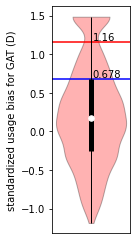

In [18]:
(aa, codon) = ("D", "GAT")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False)

In [19]:
(aa, codon) = ("F", "TTT")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False)

Bottom-most 1 values had to be discarded in order to avoid a negative threshold for the cluster F_TTT.


Bottom-most 10 values had to be discarded in order to avoid a negative threshold for the cluster R_CGT.


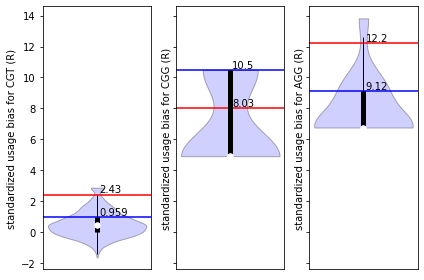

In [20]:
fig, axes = plt.subplots(ncols=3, sharey=True)
(aa, codon) = ("R", "CGT")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[0])
(aa, codon) = ("R", "CGG")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[1])
(aa, codon) = ("R", "AGG")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[2])

In [21]:
fig, axes = plt.subplots(ncols=2, sharey=True)
(aa, codon) = ("C", "TGC")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[0])
(aa, codon) = ("C", "TGT")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[1])

In [22]:
fig, axes = plt.subplots(ncols=3, sharey=True)
(aa, codon) = ("*", "TAA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[0])
(aa, codon) = ("*", "TAG")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[1])
(aa, codon) = ("*", "TGA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[2])

In [23]:
(aa, codon) = ("A", "GCC")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False)

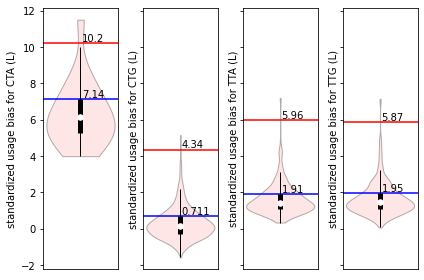

In [24]:
fig, axes = plt.subplots(ncols=4, sharey=True)
(aa, codon) = ("L", "CTA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[0])
(aa, codon) = ("L", "CTG")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[1])
(aa, codon) = ("L", "TTA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[2])
(aa, codon) = ("L", "TTG")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[3])